In [270]:
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
import os
import numpy as np
from demo_utils import plot_image
import svmbir
from scipy.interpolate import interp1d


In [272]:
def padding(array, xx, yy):
    """
    :param array: numpy array
    :param xx: desired height
    :param yy: desired width
    :return: padded array
    """

    h = array.shape[0]
    w = array.shape[1]

    a = (xx - h) // 2
    aa = xx - a - h

    b = (yy - w) // 2
    bb = yy - b - w

    return np.pad(array, pad_width=((a, aa), (b, bb)))

In [361]:
def ARC_sino_transform(sino,angles,gamma, compress_horizontally=True):
    comp_idx=int(compress_horizontally)
    num_channels=sino.shape[2]
    num_slices = sino.shape[1]
    sino_tilde= np.zeros(sino.shape)
    new_angles=np.zeros(angles.shape)
    for thetaidx, theta in enumerate(angles):
        if theta==np.pi/2:
            theta_tilde= np.pi/2
        else:
            theta_tilde= np.arctan2(gamma*np.sin(theta),np.cos(theta))

        beta= gamma/np.sqrt((gamma**2)*(np.sin(theta)**2)+np.cos(theta)**2)
        if theta_tilde==0:
            alpha=gamma
        else:
            alpha= gamma*np.sin(theta)/np.sin(theta_tilde)
        scale=[(1/alpha,1),(1,1/alpha)]
        sino_tilde[thetaidx,:,:]=padding(beta*rescale(sino[thetaidx,:,:],scale[comp_idx]),num_slices,num_channels)
        new_angles[thetaidx]=theta_tilde
    return sino_tilde, new_angles

In [357]:
def ARC_Test(gamma,theta_range,num_views,compress_horizontally=True,interpolate=False):
    num_rows = 256
    num_cols = 64
    num_slices = 33
    # display_slice = 16 # Display slice at z=-0.0
    tilt_angle=theta_range
    angle_adjust= (1-int(compress_horizontally))*np.pi/2
    # Reconstruction parameters
    snr_db = 30.0
    sharpness = 0.0
    T = 0.25
    p = 1.2
    # Display parameters
    vmin = 0.0
    vmax = 1.1
    phantom = svmbir.phantom.gen_microscopy_sample_3d(num_rows,num_cols,num_slices)
    # Generate the array of view angles
    angles = np.linspace(-tilt_angle+angle_adjust, tilt_angle+angle_adjust, num_views)

    # Generate sinogram by projecting phantom
    sino = svmbir.project(phantom, angles, max(num_rows, num_cols))

    sino_tilde, new_angles = ARC_sino_transform(sino,angles,gamma,compress_horizontally)

    # Determine resulting number of views, slices, and channels
    (num_views, num_slices, num_channels) = sino_tilde.shape

    if compress_horizontally:
        # Perform MBIR reconstruction
        recon = svmbir.recon(sino_tilde, new_angles, num_rows=num_rows, num_cols=int(num_cols/gamma), T=T, p=p, sharpness=sharpness, snr_db=snr_db )
        if interpolate:
            recon=rescale(recon,(1,1,gamma))
        else:
            phantom=rescale(phantom,(1,1,1/gamma))
    else:
        # Perform MBIR reconstruction
        recon = svmbir.recon(sino_tilde, new_angles, num_rows=int(num_rows/gamma), num_cols=num_cols, T=T, p=p, sharpness=sharpness, snr_db=snr_db )
        if interpolate:
            recon=rescale(recon,(1,gamma,1))
        else:
            phantom=rescale(phantom,(1,1/gamma,1))

    nrmse = svmbir.phantom.nrmse(recon, phantom)

    return recon, phantom, nrmse, sino, sino_tilde


In [320]:
def even_interp_sino(sino2d,bad_angles,reg_angles):
    even_sino=np.empty((sino2d.shape[0], len(reg_angles)))
    for i in range(even_sino.shape[0]):
        f = interp1d(bad_angles, sino2d[i, :], kind='linear', fill_value="extrapolate")
        even_sino[i, :] = f(reg_angles)
    return even_sino

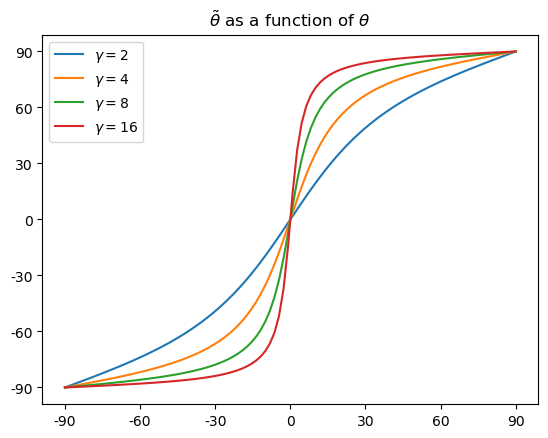

In [352]:
def theta_tildefunc(theta,gamma):
    return np.arctan2(gamma*np.sin(theta),np.cos(theta))

def alphafunc(theta,gamma):
    theta_tilde=theta_tildefunc(theta,gamma)
    return gamma*np.sin(theta)/np.sin(theta_tilde)

x = np.linspace(-np.pi/2,np.pi/2,100)
plt.plot(x,theta_tildefunc(x,2))
plt.plot(x,theta_tildefunc(x,4))
plt.plot(x,theta_tildefunc(x,8))
plt.plot(x,theta_tildefunc(x,16))
plt.legend(["$\gamma=2$","$\gamma=4$","$\gamma=8$","$\gamma=16$"])
plt.title("$\~\\theta$ as a function of $\\theta$")
plt.xticks(np.linspace(-np.pi/2,np.pi/2,7), np.arange(-90,91,180/6,dtype=int))
plt.yticks(np.linspace(-np.pi/2,np.pi/2,7), np.arange(-90,91,180/6,dtype=int))
plt.show()


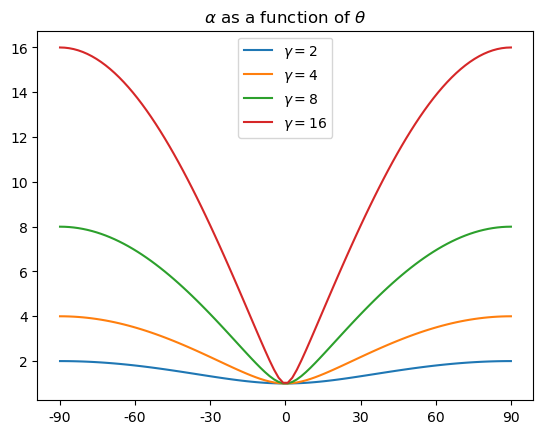

In [351]:
plt.plot(x,alphafunc(x,2))
plt.plot(x,alphafunc(x,4))
plt.plot(x,alphafunc(x,8))
plt.plot(x,alphafunc(x,16))
plt.legend(["$\gamma=2$","$\gamma=4$","$\gamma=8$","$\gamma=16$"])
plt.title("$\\alpha$ as a function of $\\theta$")
plt.xticks(np.linspace(-np.pi/2,np.pi/2,7), np.arange(-90,91,180/6,dtype=int))
plt.show()

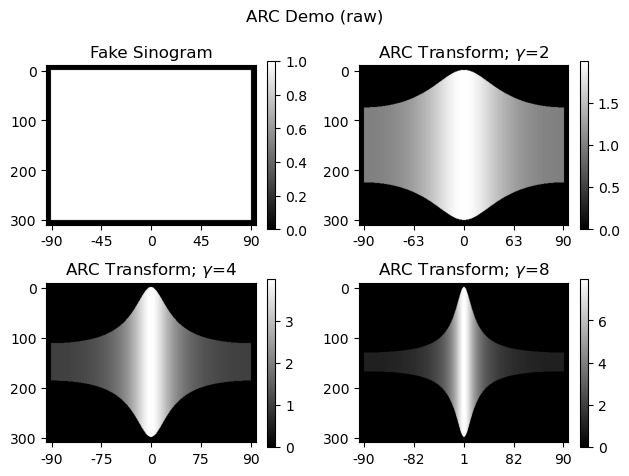

In [321]:
views=400
tilt_angle=np.pi/2
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,300,1))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
plt.imshow(np.pad(np.transpose(fake_sino[:,:,0]),(10,10)),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(10, fake_sino.shape[1]+10, 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,2)
plt.imshow(np.pad(np.transpose(fake_sino_tilde[:,:,0]),(10,10)),cmap='grey')
trans_tics=(180*fake_angles_tilde[np.round(np.linspace(0, len(fake_angles_tilde)-1, 5)).astype(int)]/np.pi).astype(int)
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), trans_tics)
plt.yticks(np.linspace(10, fake_sino.shape[1]+10, 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,3)
plt.imshow(np.pad(np.transpose(fake_sino_tilde[:,:,0]),(10,10)),cmap='grey')
trans_tics=(180*fake_angles_tilde[np.round(np.linspace(0, len(fake_angles_tilde)-1, 5)).astype(int)]/np.pi).astype(int)
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), trans_tics)
plt.yticks(np.linspace(10, fake_sino.shape[1]+10, 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,4)
plt.imshow(np.pad(np.transpose(fake_sino_tilde[:,:,0]),(10,10)),cmap='grey')
trans_tics=(180*fake_angles_tilde[np.round(np.linspace(0, len(fake_angles_tilde)-1, 5)).astype(int)]/np.pi).astype(int)
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), trans_tics)
plt.yticks(np.linspace(10, fake_sino.shape[1]+10, 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (raw)')
plt.tight_layout()

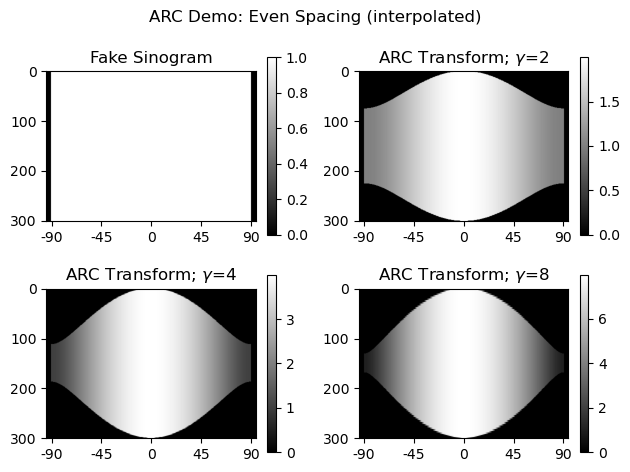

In [322]:
views=400
tilt_angle=np.pi/2
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,300,1))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(10,10))
plt.imshow(np.pad(np.transpose(fake_sino[:,:,0]),npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,fake_angles)
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,fake_angles)
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,fake_angles)
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, fake_sino.shape[0]+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo: Even Spacing (interpolated)')
plt.tight_layout()

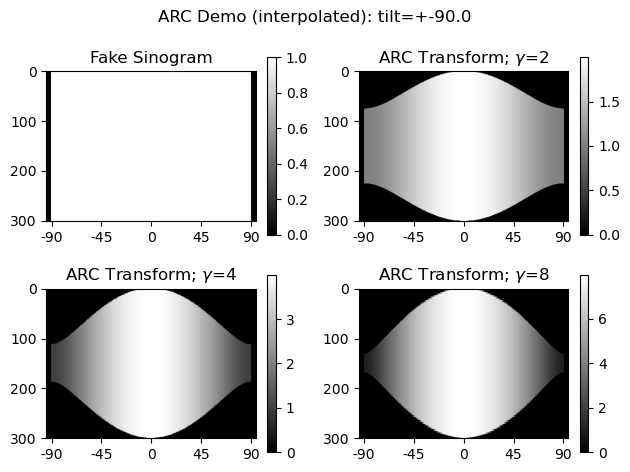

In [323]:
imwidth=400
views=int(400/1)
tilt_angle=np.pi/2
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,300,1))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(int((imwidth-views)/2)+10,int((imwidth-views)/2)+10))
plt.imshow(np.pad(np.transpose(fake_sino[:,:,0]),npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (interpolated): tilt=+-{}'.format(tilt_angle*180/np.pi))
plt.tight_layout()

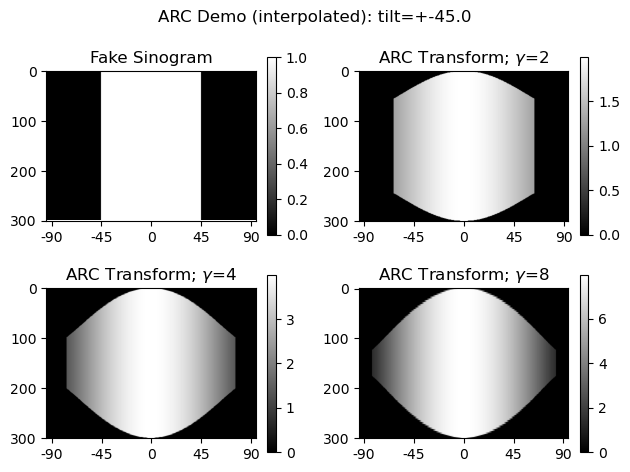

In [324]:
imwidth=400
views=int(400/2)
tilt_angle=np.pi/4
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,300,1))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(int((imwidth-views)/2)+10,int((imwidth-views)/2)+10))
plt.imshow(np.pad(np.transpose(fake_sino[:,:,0]),npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (interpolated): tilt=+-{}'.format(tilt_angle*180/np.pi))
plt.tight_layout()

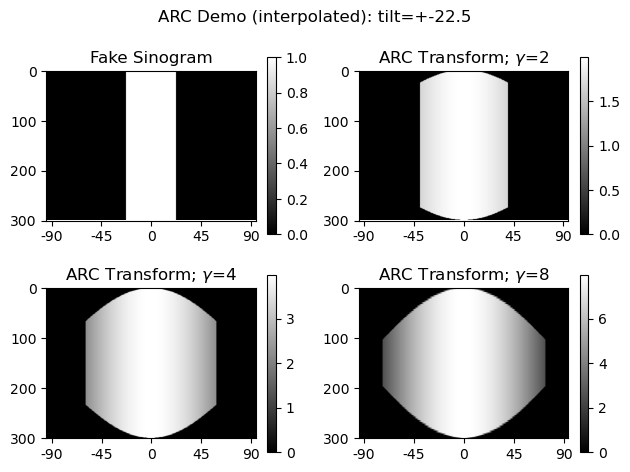

In [325]:
imwidth=400
views=int(400/4)
tilt_angle=np.pi/8
a, b = -tilt_angle, tilt_angle
fake_sino=np.ones((views,300,1))
fake_angles=np.linspace(-tilt_angle, tilt_angle, views)
plt.subplot(2,2,1)
npad=((0,0),(int((imwidth-views)/2)+10,int((imwidth-views)/2)+10))
plt.imshow(np.pad(np.transpose(fake_sino[:,:,0]),npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('Fake Sinogram')

gamma=2
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,2)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=4
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,3)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

gamma=8
fake_sino_tilde, fake_angles_tilde = ARC_sino_transform(fake_sino,fake_angles,gamma,compress_horizontally=False)
plt.subplot(2,2,4)
sino_tilde=np.transpose(fake_sino_tilde[:,:,0])
reg_ang=np.linspace(fake_angles_tilde.min(), fake_angles_tilde.max(), num=int(views*fake_angles_tilde.max()/tilt_angle))
sino_interp=even_interp_sino(sino_tilde,fake_angles_tilde,reg_ang)
npad=((0,0),(int((imwidth-len(reg_ang))/2)+10,int((imwidth-len(reg_ang))/2)+10))
plt.imshow(np.pad(sino_interp,npad),cmap='grey')
plt.xticks(np.linspace(10, imwidth+10, 5), np.arange(-90,91,180/4,dtype=int))
plt.yticks(np.linspace(0, fake_sino.shape[1], 4), np.arange(0,301,300/3,dtype=int))
plt.colorbar(fraction=0.040)
plt.title('ARC Transform; $\gamma$={}'.format(gamma))

plt.suptitle('ARC Demo (interpolated): tilt=+-{}'.format(tilt_angle*180/np.pi))
plt.tight_layout()

In [326]:
R1,GT1,err1,_ ,_ = ARC_Test(2,np.pi/6,20,compress_horizontally=True,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(4,np.pi/6,20,compress_horizontally=True,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(8,np.pi/6,20,compress_horizontally=True,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(2,np.pi/6,20,compress_horizontally=True,interpolate=False)
R5,GT5,err5,_ ,_ = ARC_Test(4,np.pi/6,20,compress_horizontally=True,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(8,np.pi/6,20,compress_horizontally=True,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/97aecc4f03001dfe93cf.2Dsvmatrix
Reconstructing axial size (rows,cols)=(256,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/a3e40e6558b6bc3a9f9f.2Dsvmatrix
teration 44, average change 0.1975 %
	iteration 45, average change 0.2009 %
	iteration 46, average change 0.1862 %
	iteration 47, average change 0.1805 %
	iteration 48, average change 0.1898 %
	iteration 49, average change 0.1799 %
	iteration 50, average change 0.1645 %
	iteration 51, average change 0.1603 %
	iteration 52, average change 0.1505 %
	iteration 53, average change 0.1523 %
	iteration 54, average change 0.1478 %
	iteration 55, average change 0.1445 %
	iteration 56, average change 0.1344 %
	iteration 57, average change 0.1376 %
	iteration 58, average change 0.1349 %
	iteration 59, average change 0.1693 %
	iteration 60, average change 0.1269 %
	iteration 61, average change 0.1286 %
	iteration 62, average change 0.1233 %
	iteration 63, average change 0

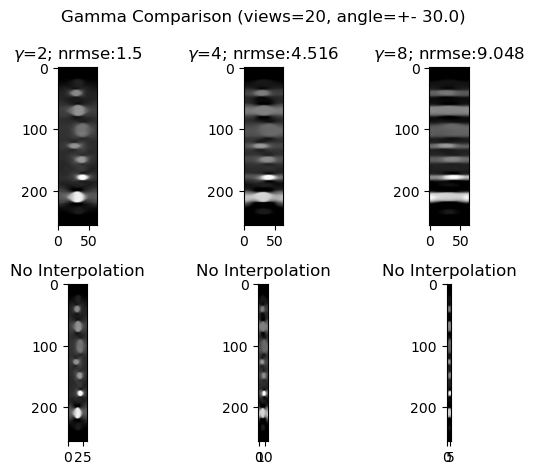

In [327]:
plt.subplot(2,3,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err1,3)))
plt.subplot(2,3,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err2,3)))
plt.subplot(2,3,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err3,3)))
plt.subplot(2,3,4)
plt.imshow(R4[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,5)
plt.imshow(R5[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,6)
plt.imshow(R6[16],cmap='grey')
plt.title('No Interpolation')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(20,180/6))
plt.tight_layout()

In [335]:
ang=np.pi/6
views=10
R1,GT1,err1,_ ,_ = ARC_Test(2,ang,views,compress_horizontally=True,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(4,ang,views,compress_horizontally=True,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(8,ang,views,compress_horizontally=True,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(2,ang,views,compress_horizontally=True,interpolate=False)
R5,GT5,err5,_ ,_ = ARC_Test(4,ang,views,compress_horizontally=True,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(8,ang,views,compress_horizontally=True,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/3bb1cb48835576c77e55.2Dsvmatrix
Reconstructing axial size (rows,cols)=(256,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/9197bf850079b14d79b8.2Dsvmatrix
e change 0.1065 %
	iteration 89, average change 0.1960 %
	iteration 90, average change 0.1106 %
	iteration 91, average change 0.0994 %
	iteration 92, average change 0.0963 %
	iteration 93, average change 0.0947 %
	iteration 94, average change 0.0930 %
	iteration 95, average change 0.0914 %
	iteration 96, average change 0.0894 %
	iteration 97, average change 0.0883 %
	iteration 98, average change 0.0869 %
	iteration 99, average change 0.0853 %
	iteration 100, average change 0.0829 %
	Reconstruction time = 12265 ms (iterations only)
Reconstructing...
	iteration 1, average change 420.3996 %
	iteration 2, average change 20.1623 %
	iteration 3, average change 5.9772 %
	iteration 4, average change 3.9470 %
	iteration 5, average change 2.4271 %
	iteration 6, average 

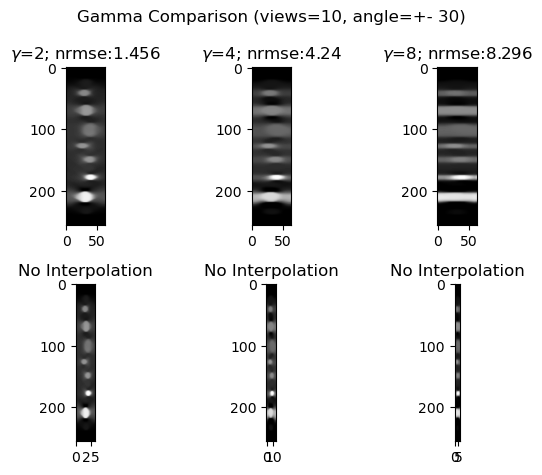

In [336]:
plt.subplot(2,3,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err1,3)))
plt.subplot(2,3,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err2,3)))
plt.subplot(2,3,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err3,3)))
plt.subplot(2,3,4)
plt.imshow(R4[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,5)
plt.imshow(R5[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,6)
plt.imshow(R6[16],cmap='grey')
plt.title('No Interpolation')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

In [362]:
ang=np.pi/6
views=5
R1,GT1,err1,_ ,_ = ARC_Test(2,ang,views,compress_horizontally=True,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(4,ang,views,compress_horizontally=True,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(8,ang,views,compress_horizontally=True,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(2,ang,views,compress_horizontally=True,interpolate=False)
R5,GT5,err5,_ ,_ = ARC_Test(4,ang,views,compress_horizontally=True,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(8,ang,views,compress_horizontally=True,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/32281d31bed3d114f889.2Dsvmatrix
Reconstructing axial size (rows,cols)=(256,32).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/db3526b9088c89a8f865.2Dsvmatrix
0.0534 %
	iteration 99, average change 0.0490 %
	iteration 100, average change 0.0513 %
	Reconstruction time = 1249 ms (iterations only)
Reconstructing...
	iteration 1, average change 421.8077 %
	iteration 2, average change 36.5980 %
	iteration 3, average change 8.6622 %
	iteration 4, average change 5.2264 %
	iteration 5, average change 4.2797 %
	iteration 6, average change 3.4883 %
	iteration 7, average change 2.3937 %
	iteration 8, average change 1.9713 %
	iteration 9, average change 1.5544 %
	iteration 10, average change 1.2252 %
	iteration 11, average change 1.0276 %
	iteration 12, average change 0.9150 %
	iteration 13, average change 0.7739 %
	iteration 14, average change 0.8330 %
	iteration 15, average change 0.7913 %
	iteration 16, average change 0.6010

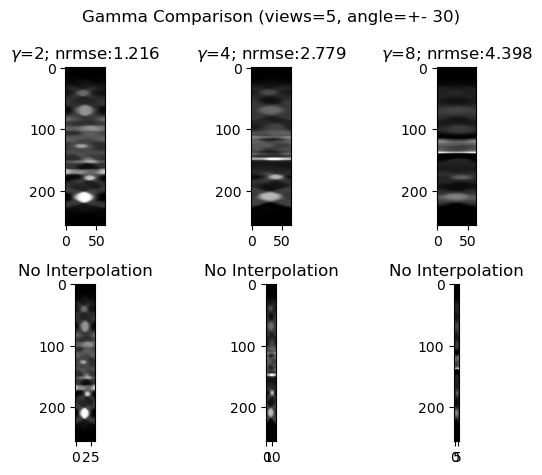

In [363]:
plt.subplot(2,3,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err1,3)))
plt.subplot(2,3,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err2,3)))
plt.subplot(2,3,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(8,round(err3,3)))
plt.subplot(2,3,4)
plt.imshow(R4[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,5)
plt.imshow(R5[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,6)
plt.imshow(R6[16],cmap='grey')
plt.title('No Interpolation')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

In [337]:
ang=np.pi/3
views=20
R1,GT1,err1,_ ,_ = ARC_Test(1,ang,views,compress_horizontally=False,interpolate=True)
R2,GT2,err2,_ ,_ = ARC_Test(2,ang,views,compress_horizontally=False,interpolate=True)
R3,GT3,err3,_ ,_ = ARC_Test(4,ang,views,compress_horizontally=False,interpolate=True)
R4,GT4,err4,_ ,_ = ARC_Test(1,ang,views,compress_horizontally=False,interpolate=False)
R5,GT5,err5,_ ,_ = ARC_Test(2,ang,views,compress_horizontally=False,interpolate=False)
R6,GT6,err6,_ ,_ = ARC_Test(4,ang,views,compress_horizontally=False,interpolate=False)

Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/aabbfffb111f7f2d5e75.2Dsvmatrix
Reconstructing axial size (rows,cols)=(256,64).
Found system matrix: /home/kweisen/.cache/svmbir/sysmatrix/aabbfffb111f7f2d5e75.2Dsvmatrix
e 0.1145 %
	iteration 50, average change 0.1342 %
	iteration 51, average change 0.0945 %
	iteration 52, average change 0.1319 %
	iteration 53, average change 0.0903 %
	iteration 54, average change 0.0911 %
	iteration 55, average change 0.0882 %
	iteration 56, average change 0.0869 %
	iteration 57, average change 0.0767 %
	iteration 58, average change 0.0788 %
	iteration 59, average change 0.0771 %
	iteration 60, average change 0.1078 %
	iteration 61, average change 0.0839 %
	iteration 62, average change 0.0763 %
	iteration 63, average change 0.0595 %
	iteration 64, average change 0.0599 %
	iteration 65, average change 0.0603 %
	iteration 66, average change 0.0570 %
	iteration 67, average change 0.0589 %
	iteration 68, average change 0.0533 %
	iteration 69, ave

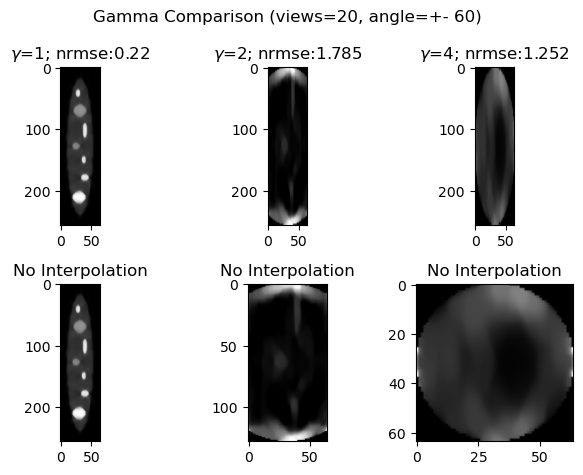

In [338]:
plt.subplot(2,3,1)
plt.imshow(R1[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(1,round(err1,3)))
plt.subplot(2,3,2)
plt.imshow(R2[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(2,round(err2,3)))
plt.subplot(2,3,3)
plt.imshow(R3[16],cmap='grey')
plt.title('$\gamma$={}; nrmse:{}'.format(4,round(err3,3)))
plt.subplot(2,3,4)
plt.imshow(R4[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,5)
plt.imshow(R5[16],cmap='grey')
plt.title('No Interpolation')
plt.subplot(2,3,6)
plt.imshow(R6[16],cmap='grey')
plt.title('No Interpolation')
plt.suptitle('Gamma Comparison (views={}, angle=+- {})'.format(views,round(ang*180/np.pi)))
plt.tight_layout()

Text(0.5, 1.0, 'Microscopy Phantom: slice 16')

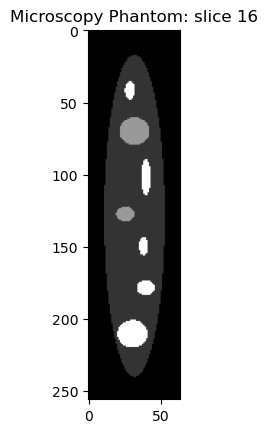

In [354]:
plt.imshow(phantom[16],cmap='grey')
plt.title('Microscopy Phantom: slice 16')